In [1]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

from aind_vr_foraging_analysis.utils.parsing import data_access
from aind_vr_foraging_analysis.utils.plotting import plotting_friction_experiment as f

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import matplotlib.ticker as ticker

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'Z:\scratch\vr-foraging\sessions'
results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\batch 5 - learning\results'

color_dict_label = {'InterSite': '#808080',
    'InterPatch': '#b3b3b3', 
    'PatchZ': '#d95f02', 'PatchZB': '#d95f02', 
    'PatchB': '#d95f02','PatchA': '#7570b3', 
    'PatchC': '#1b9e77',
    'Alpha-pinene': '#1b9e77', 
    'Methyl Butyrate': '#7570b3', 
    'Amyl Acetate': '#d95f02', 
    'Fenchone': '#7570b3', 
    'patch_single': color1,
    'patch_delayed': color2,
    'patch_no_reward': color3,
     'S': color1,
    'D': color2,
    'N': color3,   
    '90': color1,
    '60': color2,
    '0': color3,
    }

label_dict = {**{
"InterSite": '#808080',
"InterPatch": '#b3b3b3'}, 
            **color_dict_label}
import os


In [11]:
# This depends on the data from ANAYLSIS_data_collection_check_batch6.ipynb
results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\batch 6 - updating on stops\results'
df = pd.read_csv(os.path.join(results_path, 'batch6_data.csv'))

In [98]:
# Group the data as you described
df = df.rename(columns=({'stage': 'experiment'}))
patch_df = (
    # df[((df.odor_label != 'Ethyl Butyrate') & (df.site_number > 0))|((df.site_number > 1)&(df.odor_label == 'Ethyl Butyrate'))&(df['last_site'] == 1)]
    df.loc[(df['last_visit'] == 1)&(df.site_number > 0)]
    .groupby(['mouse', 'session_n', 'experiment', 'patch_label', 'patch_number'])
    .agg(
        site_number=('site_number', 'max'),
        reward_probability=('reward_probability', 'min'),
        stops=('site_number', 'max'),
        total_rewards=('cumulative_rewards', 'max'),
        consecutive_rewards = ('consecutive_rewards', 'max'),
        total_failures=('cumulative_failures', 'max'),
        consecutive_failures = ('consecutive_failures', 'max'), 
        rate_since_entry=('rate_since_entry', 'mean'), 
        rate_stops = ('rate_stops', 'mean'), 
        running_avg_rate = ('running_avg_rate', 'mean'), 
        local_average_rate = ('local_average_rate', 'mean')
        )
    .reset_index()
)
session_df = (
    patch_df
    .groupby(['mouse', 'session_n', 'experiment', 'patch_label'])
    .agg(site_number = ('site_number','sum'), 
            reward_probability = ('reward_probability','mean'), 
            stops = ('stops','mean'),
            total_stops = ('stops','sum'), 
            total_rewards = ('total_rewards','mean'),
            consecutive_rewards = ('consecutive_rewards','mean'),
            total_failures = ('total_failures','mean'),
            consecutive_failures = ('consecutive_failures','mean'), 
            patch_number = ('patch_number','nunique'), 
            rate_since_entry=('rate_since_entry', 'mean'), 
            rate_stops = ('rate_stops', 'mean'), 
            running_avg_rate = ('running_avg_rate', 'mean'), 
            local_average_rate = ('local_average_rate', 'mean')
         )
    .reset_index()
)

# These df summarizes metrics for each mouse (averages all sessions and all patches withing that session)
mouse_df = ( 
        patch_df
        .groupby(['mouse','experiment','patch_label'])
        .agg(site_number = ('site_number','sum'), 
            reward_probability = ('reward_probability','mean'), 
            stops = ('stops','mean'),
            total_stops = ('stops','sum'), 
            total_rewards = ('total_rewards','mean'),
            consecutive_rewards = ('consecutive_rewards','mean'),
            total_failures = ('total_failures','mean'),
            consecutive_failures = ('consecutive_failures','mean'), 
            patch_number = ('patch_number','nunique'), 
            rate_since_entry=('rate_since_entry', 'mean'), 
            rate_stops = ('rate_stops', 'mean'), 
            running_avg_rate = ('running_avg_rate', 'mean'), 
            local_average_rate = ('local_average_rate', 'mean')
            )
        .reset_index()
)

In [39]:
def plot_lines_aligned_to_jitter(data, ax, variable='total_rewards',
                                 group='patch_label', one_line='mouse',
                                 order=None):
    """
    Draws lines connecting jittered stripplot points so that the line
    endpoints align exactly with the jittered dots.
    """

    if order is None:
        order = sorted(data[group].unique())

    # --- Extract jittered positions from the stripplot ---
    # Seaborn creates a PathCollection for each category
    collections = [c for c in ax.collections if isinstance(c, matplotlib.collections.PathCollection)]

    # Map patch_label -> list of (x, y, mouse)
    jitter_map = {label: [] for label in order}

    for label, coll in zip(order, collections):
        offsets = coll.get_offsets()
        xs = offsets[:, 0]
        ys = offsets[:, 1]

        # Match each point back to the dataframe row
        df_sub = data[data[group] == label]

        # Ensure same length
        if len(df_sub) != len(xs):
            print("Warning: mismatch between jitter points and data rows")
            continue

        for (x, y), (_, row) in zip(offsets, df_sub.iterrows()):
            jitter_map[label].append((x, y, row[one_line]))

    # --- Draw lines per mouse ---
    for mouse in data[one_line].unique():
        xs = []
        ys = []

        for label in order:
            pts = [(x, y) for (x, y, m) in jitter_map[label] if m == mouse]
            if len(pts) == 1:
                xs.append(pts[0][0])
                ys.append(pts[0][1])
            else:
                # No point for this mouse in this category
                xs.append(None)
                ys.append(None)

        # Only draw if both points exist
        if None not in xs:
            ax.plot(xs, ys, color='black', alpha=0.5, linewidth=1.2, zorder=3)


In [42]:
def stripplot_with_lines(ax, data, variable, group, one_line, order, jitter=0.12):
    """
    Draws jittered points and perfectly aligned connecting lines.
    Replaces seaborn.stripplot + plot_lines.
    """

    # Map categories to x positions
    x_map = {label: i for i, label in enumerate(order)}

    # Store jittered positions per mouse
    jittered_positions = {}

    for label in order:
        df_sub = data[data[group] == label]

        # Generate jitter for each point
        xs = x_map[label] + np.random.uniform(-jitter, jitter, size=len(df_sub))
        ys = df_sub[variable].values

        # Plot jittered points
        ax.scatter(xs, ys, color='black', alpha=0.5, s=30, zorder=3)

        # Save jittered positions per mouse
        for (mouse, x, y) in zip(df_sub[one_line], xs, ys):
            if mouse not in jittered_positions:
                jittered_positions[mouse] = {}
            jittered_positions[mouse][label] = (x, y)

    # Draw lines per mouse
    for mouse, pts in jittered_positions.items():
        if len(pts) == 2:  # both patch labels exist
            xs = [pts[label][0] for label in order]
            ys = [pts[label][1] for label in order]
            ax.plot(xs, ys, color='black', alpha=0.5, linewidth=1.2, zorder=4)


In [71]:
def plot_experiment_patch_boxplots(df, variable='total_rewards',
                                   group = 'session_n',
                                   patch_order=['90', '60'],
                                   experiments_order=None):
    """
    Creates a 2x2 layout of boxplots:
        - Two experiments (columns)
        - Two patch labels (boxplots per experiment)
    Adds:
        - Lines connecting patch labels per mouse
        - Significance annotation per experiment
    """

    if experiments_order is None:
        experiments_order = sorted(df['experiment'].unique())

    fig, axes = plt.subplots(1, len(experiments_order), figsize=(8, 4), sharey=True)

    if len(experiments_order) == 1:
        axes = [axes]  # ensure iterable

    for i, exp in enumerate(experiments_order):
        ax = axes[i]
        sub = df[df['experiment'] == exp]

        # --- Boxplot ---
        sns.boxplot(
            data=sub,
            x='patch_label',
            y=variable,
            order=patch_order,
            ax=ax,
            width=0.6,
            fliersize=0
        )

        # # --- Jittered points (optional, but helps visualization) ---
        # sns.stripplot(
        #     data=sub,
        #     x='patch_label',
        #     y=variable,
        #     order=patch_order,
        #     ax=ax,
        #     color='black',
        #     alpha=0.5,
        #     jitter=True,
        #     size=4
        # )

        # # --- Lines connecting patch labels per mouse ---
        # f.plot_lines(
        #     data=sub,
        #     ax=ax,
        #     variable=variable,
        #     group='patch_label',
        #     one_line='mouse',
        #     order=patch_order
        # )
        stripplot_with_lines(
            ax=ax,
            data=sub,
            variable=variable,
            group='patch_label',
            one_line=group,
            order=patch_order
        )

        # --- Significance annotation ---
        try:
            f.plot_significance(
                general_df=sub,
                axes=ax,
                variable=variable,
                group='patch_label',
                conditions=patch_order
            )
        except Exception as e:
            print(f"Significance failed for {exp}: {e}")

        ax.set_title(f"{exp}")
        
        ax.yaxis.set_major_locator( ticker.MaxNLocator(nbins=5, steps=[1, 2, 5]) ) 

        ax.set_xlabel("")
        if i == 0:
            ax.set_ylabel(variable)
        else:
            ax.set_ylabel("")

        sns.despine()

    plt.tight_layout()
    plt.show()


In [ ]:
plot_experiment_patch_boxplots(
    df=mouse_df,
    variable='reward_probability',
    group = 'mouse',
    patch_order=['odor_90', 'odor_60'],
    experiments_order=['stops_offset', 'rewards_offset']  # optional
)


reward_probability p-value: 0.045715717949794
reward_probability p-value: 0.09986213268749322


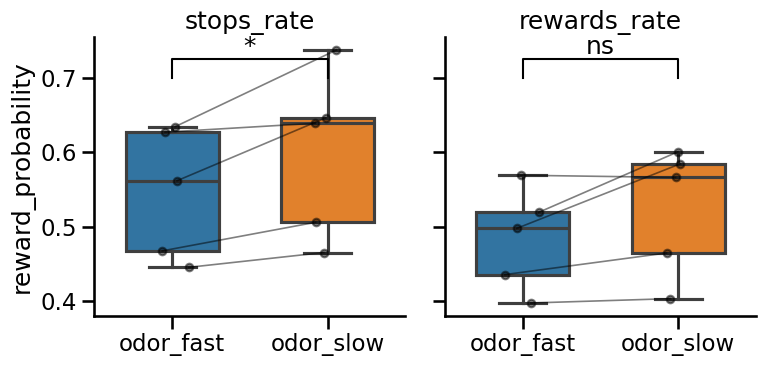

In [99]:
plot_experiment_patch_boxplots(
    df=mouse_df,
    variable='reward_probability',
    group = 'mouse',
    patch_order=['odor_fast', 'odor_slow'],
    experiments_order=['stops_rate', 'rewards_rate']  # optional
)

807086
reward_probability p-value: 7.466023061606881e-05
reward_probability p-value: 0.8061346804741099


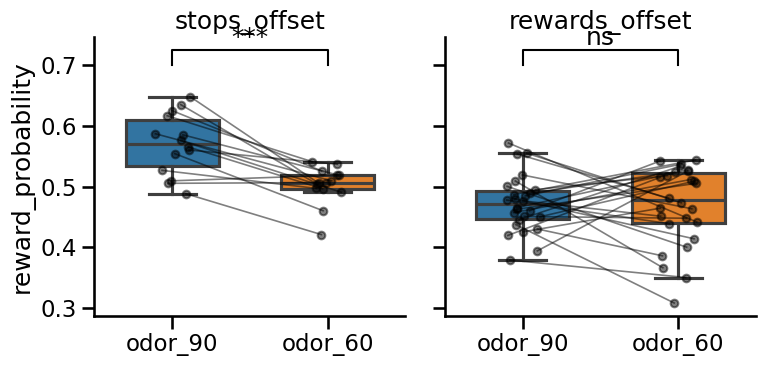

807093
reward_probability p-value: 0.012000906386684114
reward_probability p-value: 0.0829232482199869


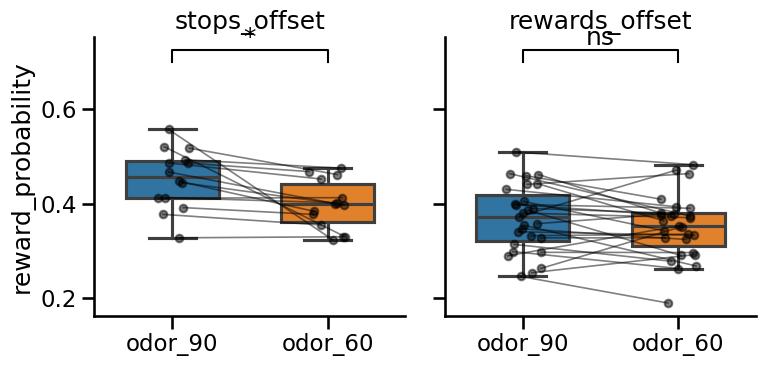

808729
reward_probability p-value: nan
reward_probability p-value: 0.1677063281389901


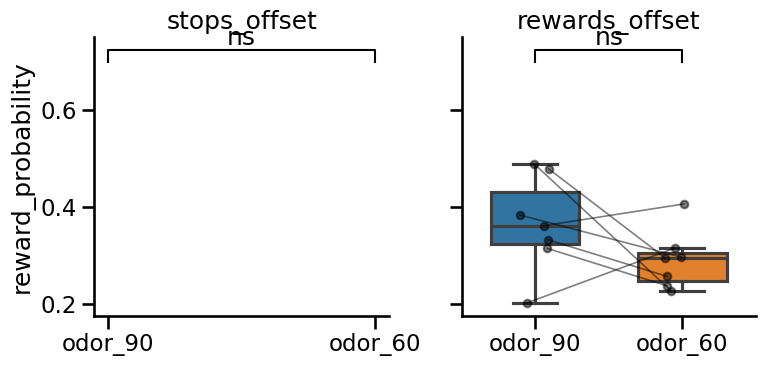

815102
reward_probability p-value: 0.0006850291129435497
reward_probability p-value: 4.8838350377291026e-05


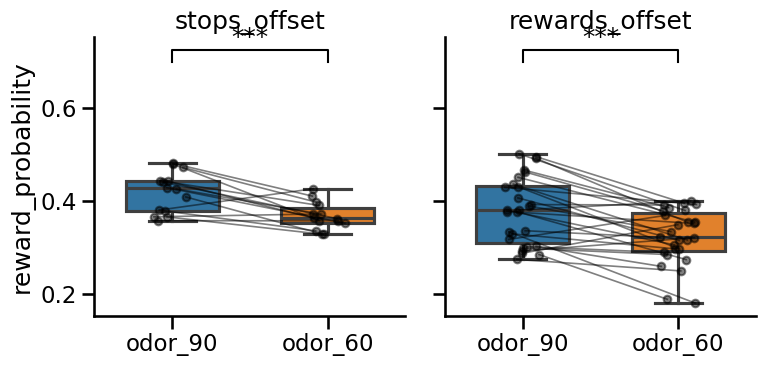

815103
reward_probability p-value: 0.006564999385256155
reward_probability p-value: 0.11834426075234804


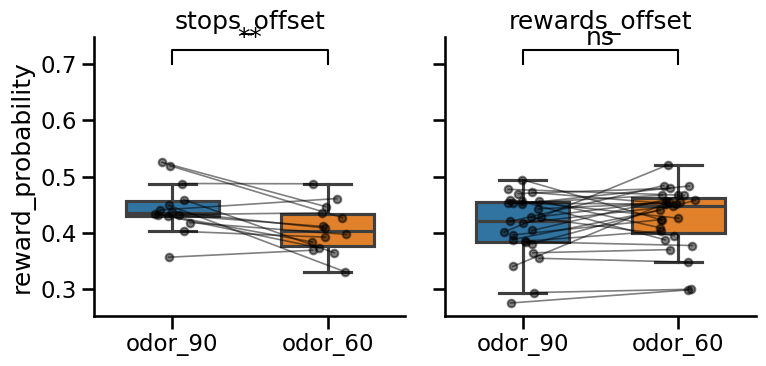

815104
reward_probability p-value: nan
reward_probability p-value: 0.016863965425625328


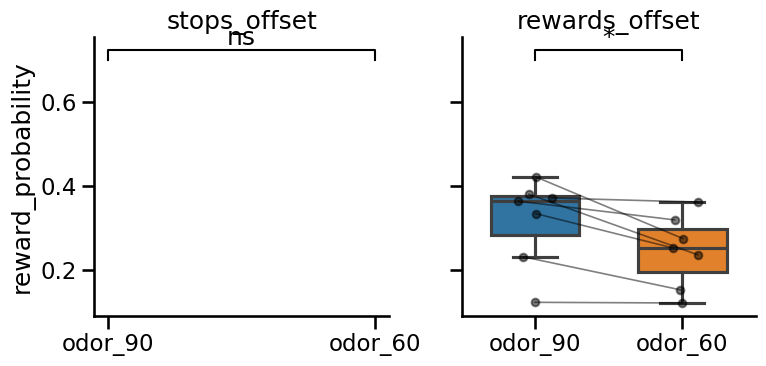

828417
reward_probability p-value: 0.5153419432792715
reward_probability p-value: 0.04946246377299575


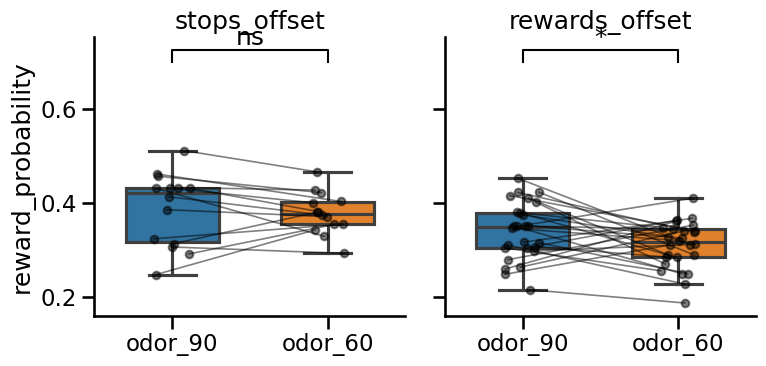

828418
reward_probability p-value: 0.002710916103240809
reward_probability p-value: 0.0661977638378597


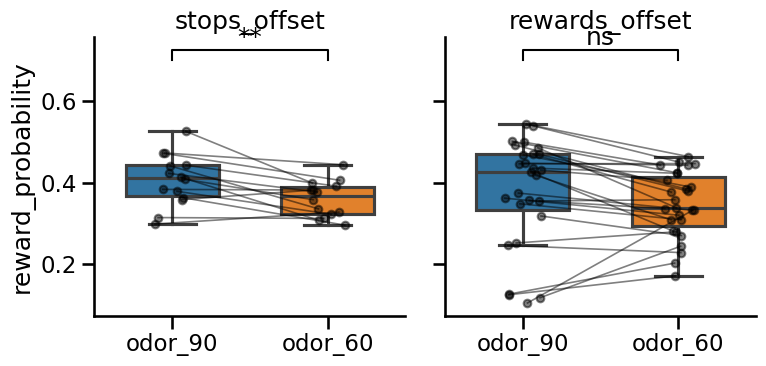

828420
reward_probability p-value: nan
reward_probability p-value: 1.6128167262952338e-05


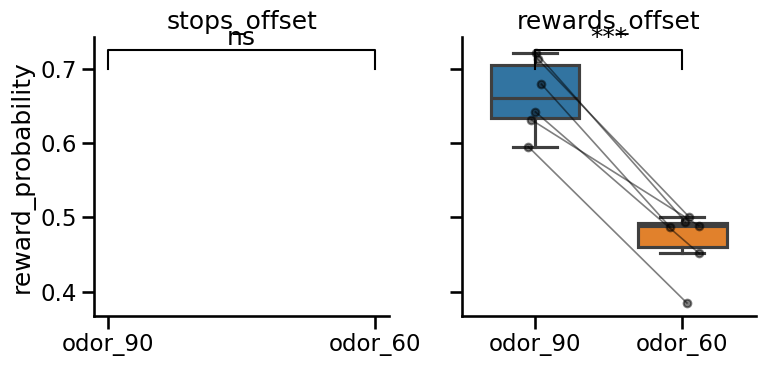

828423
reward_probability p-value: nan
reward_probability p-value: nan


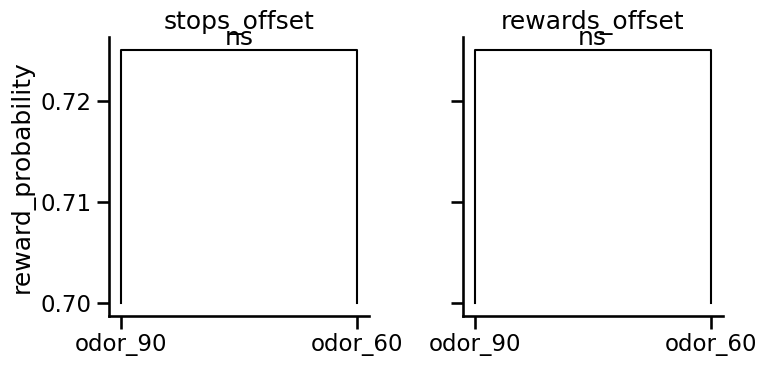

828425
reward_probability p-value: nan
reward_probability p-value: nan


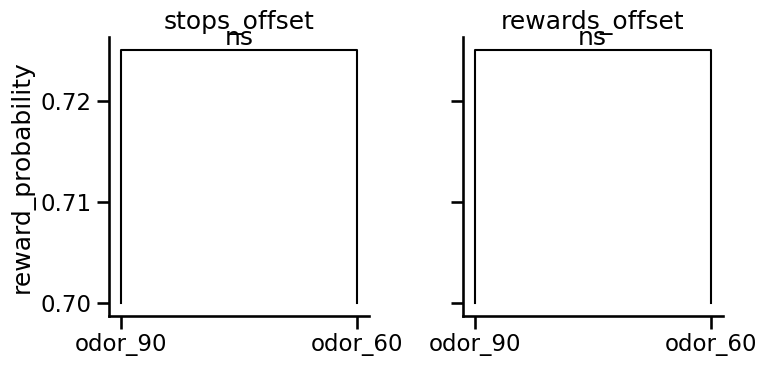

In [100]:
for mouse in session_df.mouse.unique():
    print(mouse)
    plot_experiment_patch_boxplots(
        df=session_df.loc[session_df.mouse == mouse],
        variable='reward_probability',
        group = 'session_n',
        patch_order=['odor_90', 'odor_60'],
        experiments_order=['stops_offset', 'rewards_offset']  # optional
    )


807086
total_rewards p-value: 2.408554712023367e-11
reward_probability p-value: 0.8061346804741099
stops p-value: 1.820951436752413e-07
total_failures p-value: 0.002366692383999082
consecutive_failures p-value: 0.0011751011362094149
patch_number p-value: 0.0008174512948166275
807093
total_rewards p-value: 4.1731741125173555e-12
reward_probability p-value: 0.0829232482199869
stops p-value: 3.6922003661375846e-05
total_failures p-value: 0.10766266462295113
consecutive_failures p-value: 0.9656117059462273
patch_number p-value: 0.65094823164466
808729
total_rewards p-value: 0.19330885442523352
reward_probability p-value: 0.1677063281389901
stops p-value: 0.81997535599797
total_failures p-value: 0.3714964563088344
consecutive_failures p-value: 0.04558475509101322
patch_number p-value: 0.7561015938882549
815102
total_rewards p-value: 2.000452011161876e-07
reward_probability p-value: 4.8838350377291026e-05
stops p-value: 0.7061462742713975
total_failures p-value: 0.04496012872133763
consecuti

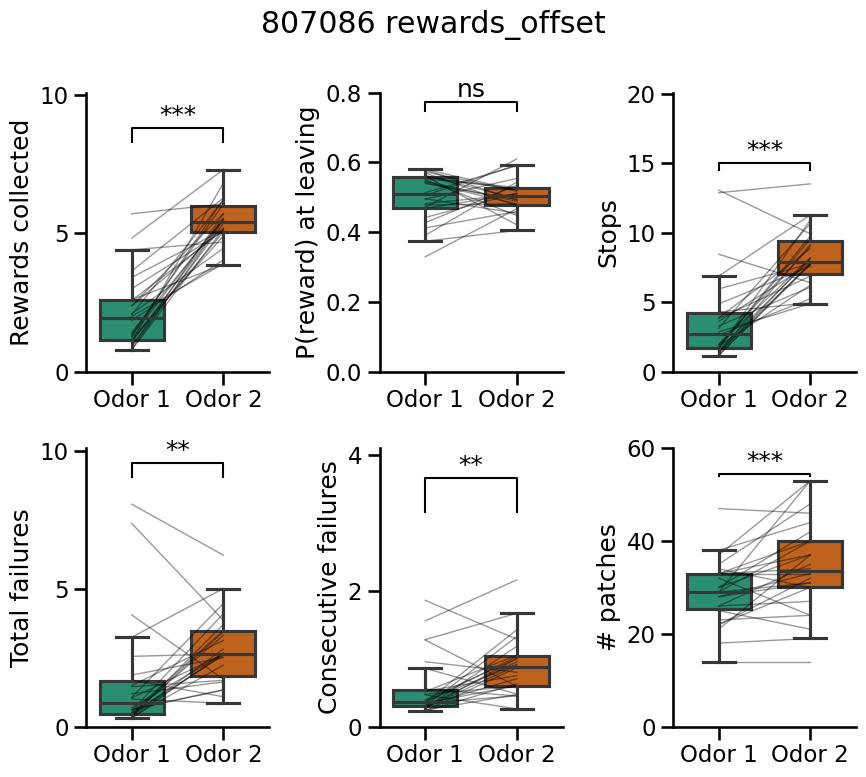

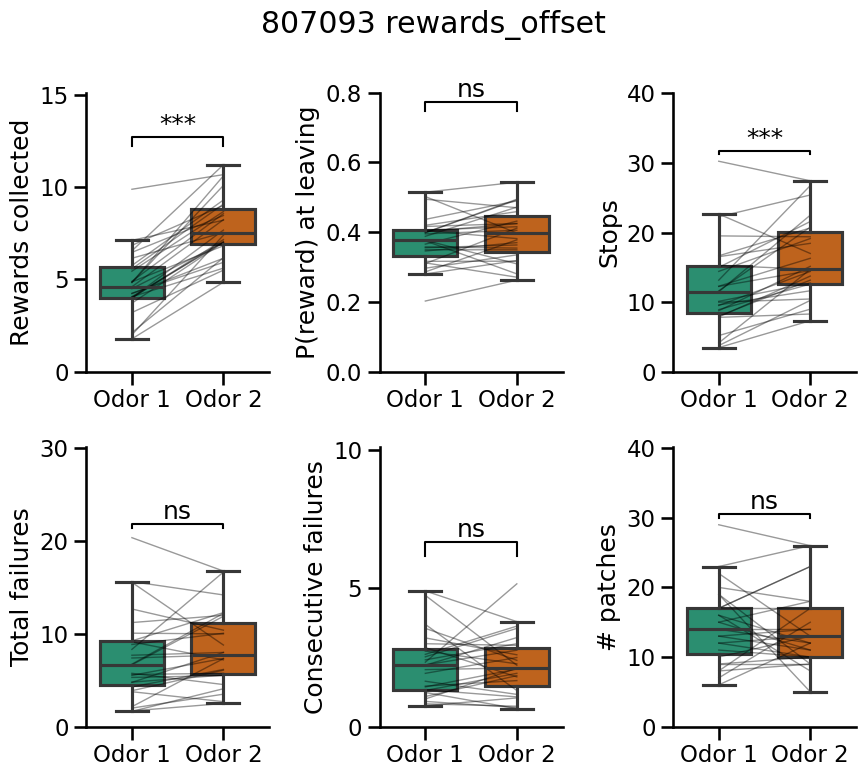

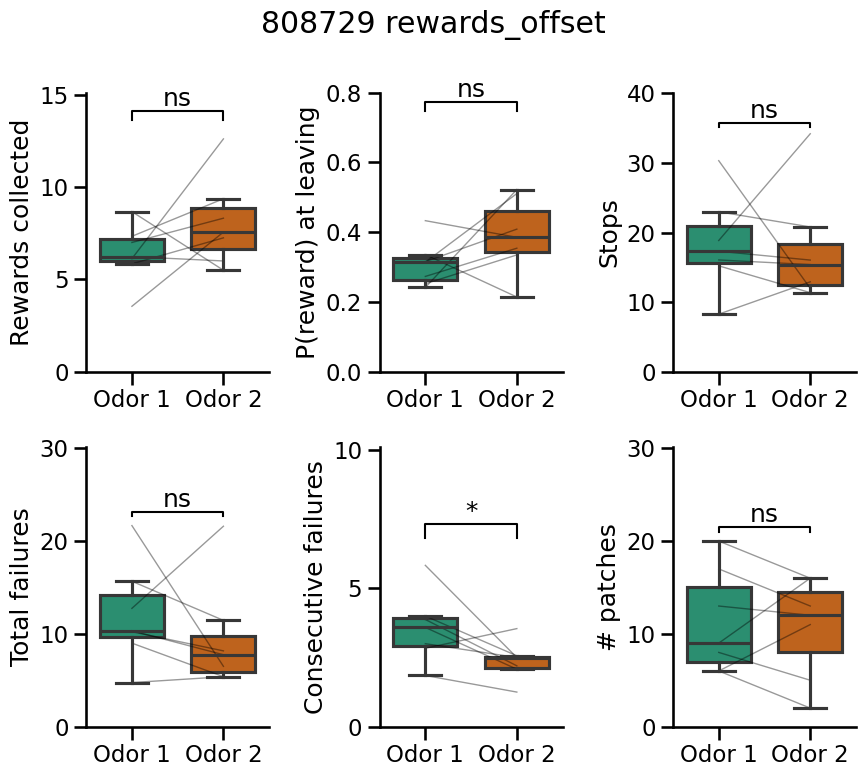

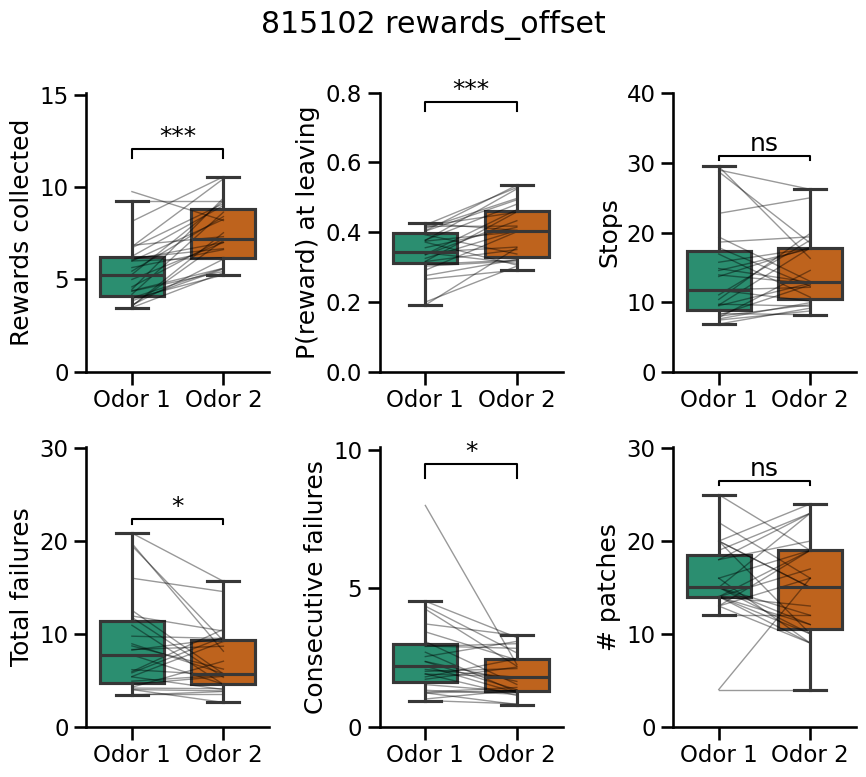

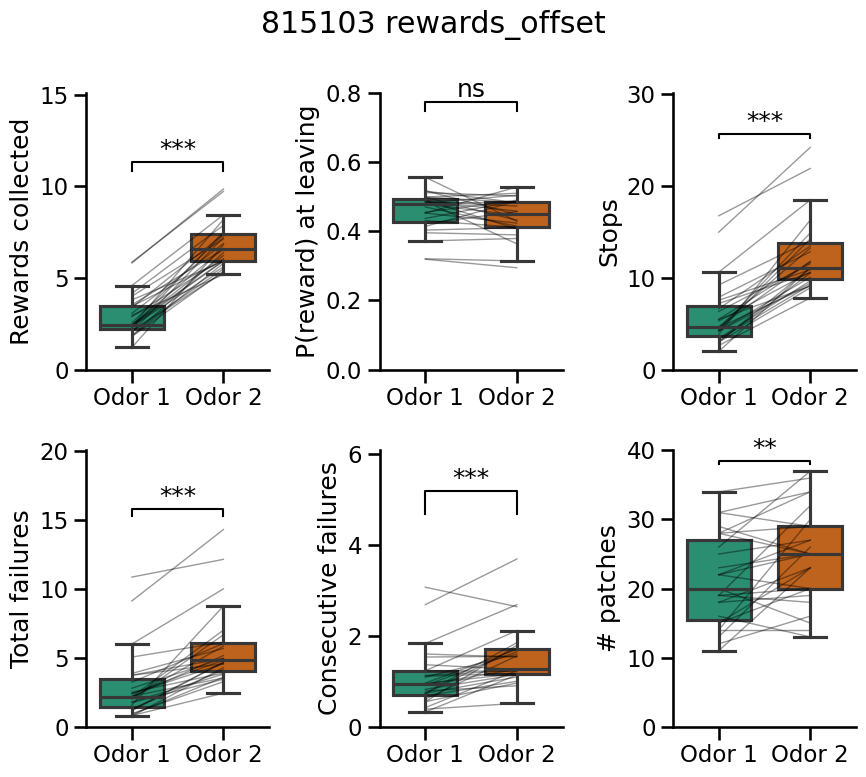

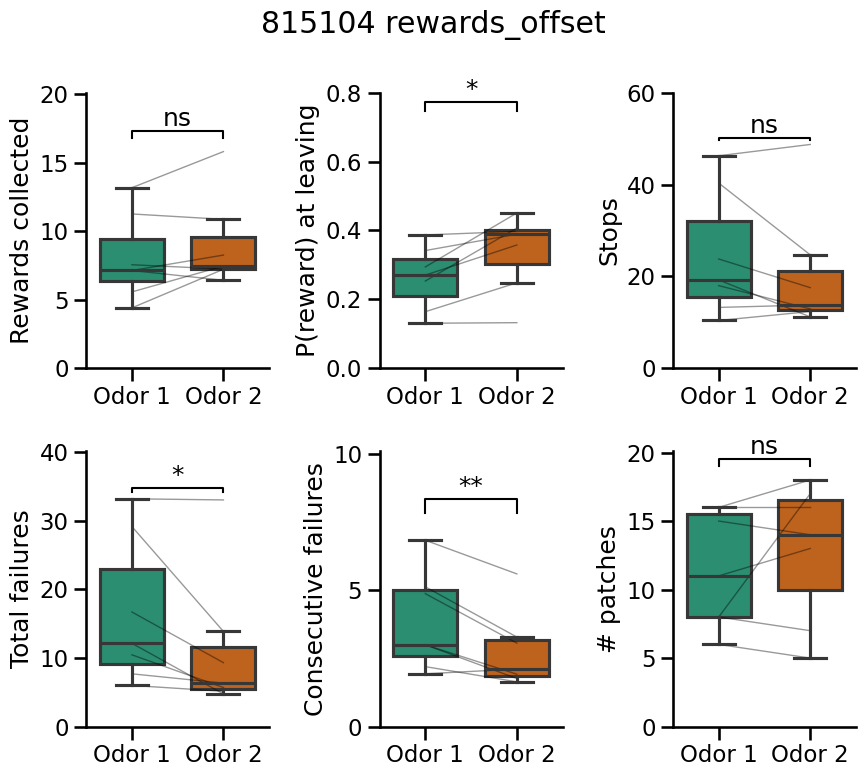

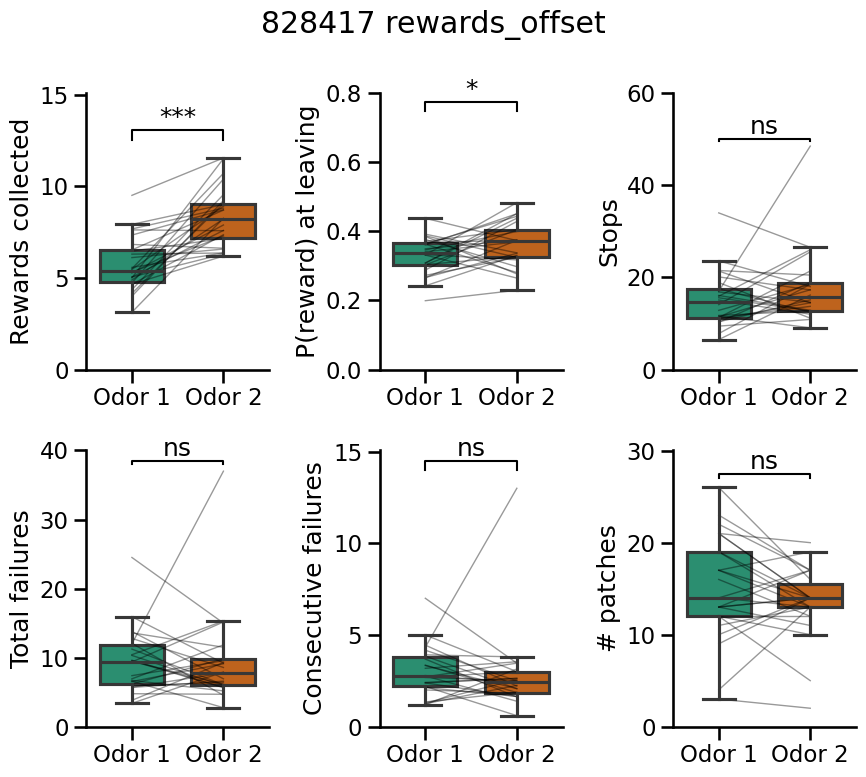

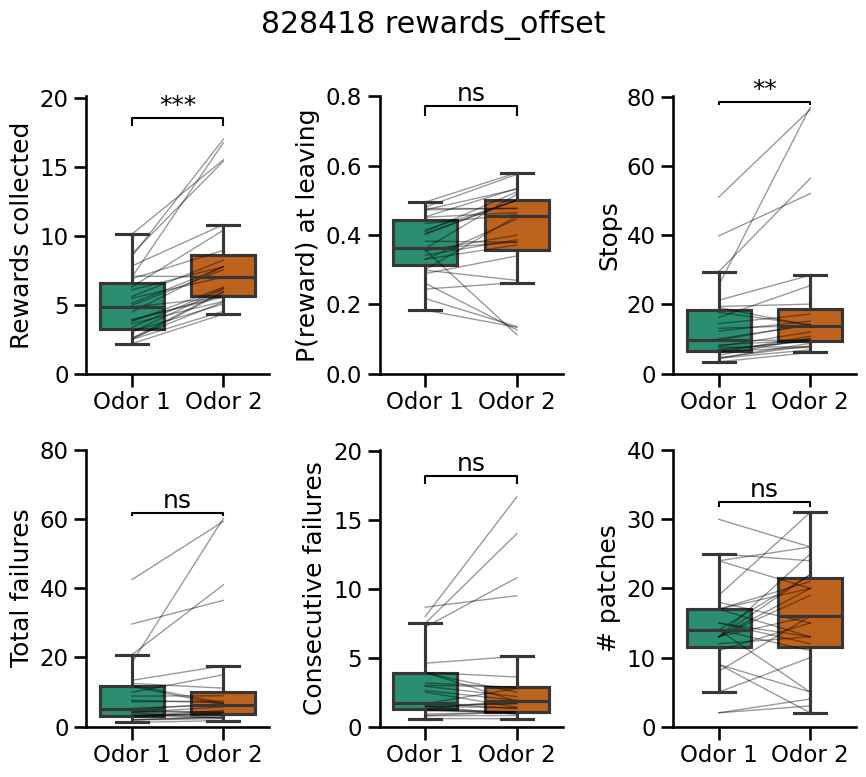

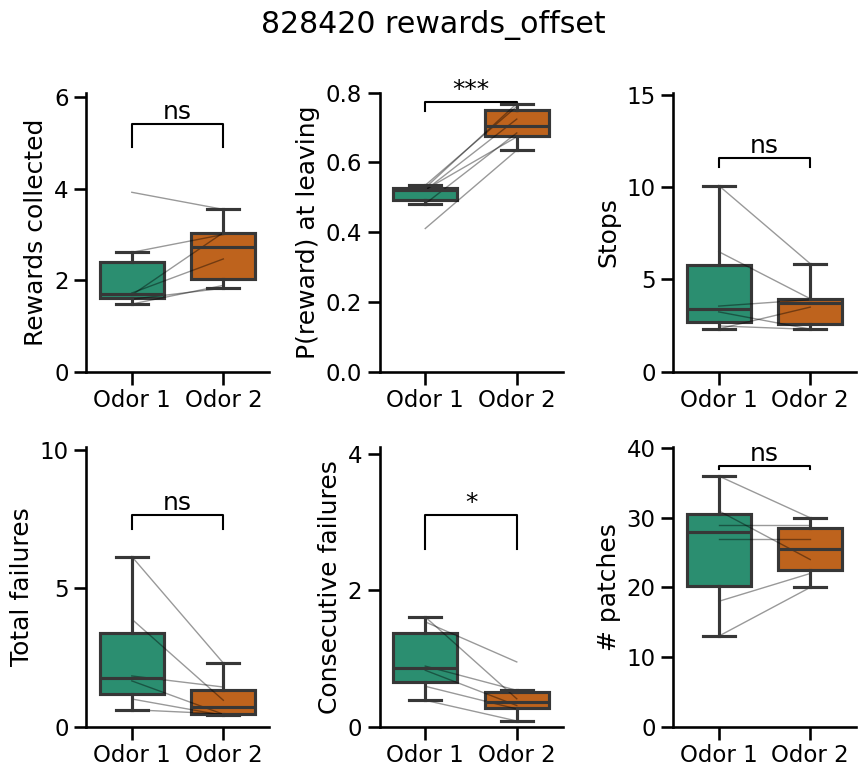

In [101]:
experiment = 'rewards_offset'
session_df = session_df.loc[(session_df.patch_label != 'odor_0')&(session_df.experiment == experiment)].copy()
for mouse in session_df.loc[session_df.experiment == experiment].mouse.unique():
    with PdfPages(results_path+f'/summary_results_{experiment}_per_mouse_{mouse}.pdf') as pdf:
        print(mouse)
        odor_labels = [label for label in session_df.loc[session_df.mouse == mouse].patch_label.unique() if label != 'odor_0']
        f.summary_main_variables(session_df.loc[session_df.mouse == mouse], experiment, condition='session_n', save=pdf, odor_labels=odor_labels)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# experiment_list = ['rewards_offset', 'stops_offset']
experiment_list = ['odor_60']
mouse_list = mouse_df.loc[(mouse_df.experiment.isin(experiment_list))]['mouse'].unique()
plot = mouse_df.loc[mouse_df['mouse'].isin(mouse_list)]

for ax, variable in zip(axes.flatten(), ['reward_probability', 'stops', 'total_rewards', 'total_failures', 'patch_number', 'consecutive_failures']):
    f.plot_experiments_comparison_with_odors(ax, plot, variable, experiments= experiment_list + ['data_collection'])
fig.savefig(results_path+'/summary_experiments_all_odors_distance.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# for experiment in general_df.experiment.unique():
with PdfPages(results_path+f'/summary_general_results_control_all.pdf') as pdf:
    f.summary_main_variables(mouse_df.loc[mouse_df.experiment == 'data_collection'], 'N = 5 mice', condition='mouse', save=pdf, odor_labels=['90','60'])

In [ ]:
variable = 'reward_probability'

In [ ]:
## Difference between the two patches per mouse
mice = df['mouse'].unique()
n_mice = len(mice)
n_cols = 5  # adjust number of columns as needed
n_rows = int(np.ceil(n_mice / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False, sharey=True)

for idx, mouse in enumerate(mice):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    mouse_group = session_df.loc[(session_df.patch_label != '0')&(session_df['mouse'] == mouse)&(session_df['experiment'] == 'data_collection')&(session_df['session_n'] > 25)]

    # Plot boxplot
    sns.boxplot(
        x='patch_label',
        y=variable,
        palette=color_dict_label,
        data=mouse_group,
        order=odor_labels,
        zorder=10,
        width=0.7,
        ax=ax,
        fliersize=0
    )

    # Plot session lines
    f.plot_lines(
        data=mouse_group,
        ax=ax,
        variable=variable,
        one_line='session_n',
        order=odor_labels
    )

    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Odor 1', 'Odor 2'])
    # ax.set_ylabel('Rate since entry')

    sns.despine(ax=ax)

# Turn off empty axes
for idx in range(n_mice, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row, col].axis('off')

fig.tight_layout()
plt.show()
fig.savefig(results_path + f'/grid_mouse_y_{variable}_x_patch_label.pdf', bbox_inches='tight')


In [ ]:
for variable in ['reward_probability', 'stops', 'total_rewards', 'consecutive_rewards', 'total_failures', 'consecutive_failures', 'patch_number', 'total_water']:
    with PdfPages(results_path+f'/across_sessions_{variable}.pdf') as pdf:
        f.across_sessions_one_plot(session_df.loc[session_df.patch_label != 'Amyl Acetate'], variable, save=pdf)

In [ ]:
sns.boxplot(
    data=session_df,
    x='experiment',
    y='reward_probability',
    palette=color_dict_label,
    hue='patch_label',
    hue_order=odor_labels
)
sns.despine()

In [ ]:
mouse_df = mouse_df.loc[mouse_df.mouse != '789913']

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for ax, variable in zip(axes.flatten(), ['reward_probability', 'stops', 'total_rewards', 'total_failures', 'patch_number', 'consecutive_failures']):
    f.plot_experiments_comparison_with_odors(ax, mouse_df, variable, experiments= ['data_collection', 'odor_60', 'odor_90'])
fig.savefig(results_path+'/summary_experiments_all_odors_friction.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(data=mouse_df.loc[mouse_df.patch_label == '90'], x='running_avg_rate', y='reward_probability', color=color1)
sns.regplot(data=mouse_df.loc[mouse_df.patch_label == '60'], x='running_avg_rate', y='reward_probability', color=color2)
plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Dashed gray line
plt.xlabel('Running average rate')
plt.ylabel('Reward probability')
sns.despine()

In [ ]:
# Filter the summary_df to only keep patches they visit
summary_df = df.loc[((df.site_number == 0) & (df.is_choice == 1)) | (df.site_number != 0)]
summary_df = summary_df.loc[summary_df.label == 'OdorSite']
summary_df = summary_df.loc[summary_df.engaged == 1]

# Group by mouse, experiment, and patch_label to calculate the number of unique patches visited
patch_df = summary_df.groupby(['mouse', 'experiment','session',  'patch_label']).agg({'patch_number': 'nunique'}).reset_index()

# Merge the patch_df back with summary_df to calculate the number of patches attempted
final_df = pd.merge(summary_df, patch_df, on=['mouse', 'session', 'experiment', 'patch_label'], how='left', suffixes=('', '_attempted'))

# Group by mouse, site_number, experiment, and patch_label to calculate the number of patches visited and attempted
final_df = final_df.groupby(['mouse', 'cumulative_rewards', 'session', 'experiment', 'patch_label']).agg({'patch_number': 'nunique', 'patch_number_attempted': 'mean', }).reset_index()

# Calculate the fraction of patches visited
final_df['fraction_visited'] = final_df['patch_number'] / final_df['patch_number_attempted']
final_df = final_df.loc[final_df.patch_label != '0']

new_df = final_df.groupby(['mouse','experiment', 'session', 'cumulative_rewards', 'patch_label']).fraction_visited.mean().reset_index()
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharey=True)
for ax, mouse in zip(axes.flatten(), new_df.mouse.unique()):
    sns.lineplot(data=new_df.loc[(new_df.mouse == mouse)], x='cumulative_rewards', y='fraction_visited', hue='patch_label', ci=None, ax=ax, style='experiment', palette=[color2, color1])

    ax.set_xlim(0, 20)
    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('Total Rewards')
    ax.set_ylabel('Fraction visited')
    sns.despine()
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

In [ ]:
results = {}

for exp in new_df['experiment'].unique():  # solid vs dashed
    df_exp = new_df[new_df['experiment'] == exp]
    df_exp = df_exp.loc[df_exp.cumulative_rewards <= 20]
    # pivot to get orange vs green side by side
    pivot = df_exp.pivot_table(
        index='cumulative_rewards',
        columns='patch_label',
        values='fraction_visited'
    )
    
    pivot = pivot.dropna(subset=[orange_label, green_label])  # require both present
    pivot = pivot.sort_index()

    x = pivot.index.values
    diff = pivot[orange_label].values - pivot[green_label].values

    area_abs = np.trapz(np.abs(diff), x)
    area_signed = np.trapz(diff, x)
    
    # pick your two patch labels (replace with actual values for orange and green)
    orange_label = '90'
    green_label  = '60'
    
    # compute absolute area difference using trapezoidal rule
    x = pivot.index.values
    area_90 = np.trapz(pivot[orange_label], x)
    area_60 = np.trapz(pivot[green_label], x)

    area_abs = area_90 - area_60
    results[exp] = {'area_90': area_90, 'area_60': area_60, 'area_abs': area_abs}

print(results)


In [ ]:
# Filter the summary_df to only keep patches they visit
summary_df = df.loc[((df.site_number == 0) & (df.is_choice == 1)) | (df.site_number != 0)]
summary_df = summary_df.loc[summary_df.engaged == 1]
summary_df = summary_df.loc[summary_df.label == 'OdorSite']

# Group by mouse, experiment, and patch_label to calculate the number of unique patches visited
patch_df = summary_df.groupby(['mouse', 'experiment','session',  'patch_label']).agg({'patch_number': 'nunique'}).reset_index()

# Merge the patch_df back with summary_df to calculate the number of patches attempted
final_df = pd.merge(summary_df, patch_df, on=['mouse', 'session', 'experiment', 'patch_label'], how='left', suffixes=('', '_attempted'))

# Group by mouse, site_number, experiment, and patch_label to calculate the number of patches visited and attempted
final_df = final_df.groupby(['mouse', 'site_number', 'session', 'experiment', 'patch_label']).agg({'patch_number': 'nunique', 'patch_number_attempted': 'mean', }).reset_index()

# Calculate the fraction of patches visited
final_df['fraction_visited'] = final_df['patch_number'] / final_df['patch_number_attempted']
final_df = final_df.loc[final_df.patch_label != '0']

new_df = final_df.groupby(['mouse','experiment', 'session', 'site_number', 'patch_label']).fraction_visited.mean().reset_index()
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharey=True)
for ax, mouse in zip(axes.flatten(), new_df.mouse.unique()):
    sns.lineplot(data=new_df.loc[(new_df.mouse == mouse)], x='site_number', y='fraction_visited', hue='patch_label', ci=None, ax=ax, style='experiment', palette=[color2, color1])

    ax.set_xlim(0, 20)
    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('Odor site number')
    ax.set_ylabel('Fraction visited')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    sns.despine()
    plt.tight_layout()

In [ ]:
results = {}

for exp in new_df['experiment'].unique():  # solid vs dashed
    df_exp = new_df[new_df['experiment'] == exp]
    df_exp = df_exp.loc[df_exp.site_number <= 20]
    # pivot to get orange vs green side by side
    pivot = df_exp.pivot_table(
        index='site_number',
        columns='patch_label',
        values='fraction_visited'
    )
    
    pivot = pivot.dropna(subset=[orange_label, green_label])  # require both present
    pivot = pivot.sort_index()

    x = pivot.index.values
    diff = pivot[orange_label].values - pivot[green_label].values

    area_abs = np.trapz(np.abs(diff), x)
    area_signed = np.trapz(diff, x)
    
    # pick your two patch labels (replace with actual values for orange and green)
    orange_label = '90'
    green_label  = '60'
    
    # compute absolute area difference using trapezoidal rule
    x = pivot.index.values
    area_90 = np.trapz(pivot[orange_label], x)
    area_60 = np.trapz(pivot[green_label], x)

    area_abs = area_90 - area_60
    results[exp] = {'area_90': area_90, 'area_60': area_60, 'area_abs': area_abs}

print(results)


In [ ]:
df_results = df.loc[(df.site_number > 0) & (df.last_site == 1)].groupby(['mouse', 'session', 'patch_number']).agg({
    'consecutive_failures':  "first",
    'cumulative_rewards':  "first",
    'reward_probability':  "first",
    'site_number': 'first',
}).reset_index()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10, 4.5))
ax = axes[0]
plot = df_results.groupby(['cumulative_rewards','consecutive_failures']).reward_probability.mean().unstack()
sns.heatmap(plot, cmap='viridis_r', fmt='.1f', ax=ax, cbar=False, vmin = 0.1, vmax =0.7)
ax.set_ylabel('Cumulative Rewards')
ax.set_xlabel('Consecutive Failures')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_yticklabels(ax.get_yticks().astype(int))
ax.tick_params(axis='x', labelbottom=True)
ax.set_xlim(0,20)
ax.set_ylim(0,20)

ax = axes[1]
plot = df_results.groupby(['site_number','cumulative_rewards']).reward_probability.mean().unstack()
sns.heatmap(plot, cmap='viridis_r', fmt='.1f', ax=ax, cbar=True, vmin = 0.1, vmax =0.7, cbar_kws={'label': 'P(Reward)'})
ax.set_xlabel('Cumulative Rewards')
ax.set_ylabel('Stops')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_yticklabels(ax.get_yticks().astype(int))
ax.tick_params(axis='x', labelbottom=True)
ax.set_xlim(0,20)
ax.set_ylim(0,20)

plt.tight_layout()

In [ ]:
# Get unique mice
mice = df_results['mouse'].unique()
n_mice = len(mice)

# Grid size (adjust as needed)
cols = 3
rows = -(-n_mice // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, mouse in enumerate(mice):
    ax = axes[i]
    mouse_df = df_results[(df_results['mouse'] == mouse)]

    # Create the pivot table for the heatmap
    plot = (
        mouse_df.groupby(['consecutive_failures','cumulative_rewards',])
        .reward_probability.mean()
        .unstack()
    )
    
    last_hm = sns.heatmap(plot, ax=ax, cmap='viridis_r', cbar=False)
    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('Cumulative Rewards')
    ax.set_ylabel('Consecutive Failures')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_xticklabels(ax.get_xticks().astype(int))
    ax.set_yticklabels(ax.get_yticks().astype(int))
    ax.tick_params(axis='x', labelbottom=True)
    ax.invert_yaxis()  # Invert y-axis to have the first row at the top 
# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Reward Probability')

plt.savefig(os.path.join(results_path, 'real_grid_mouse_x_cumrewards_y_consfailures.pdf'), bbox_inches='tight')
plt.show()



In [ ]:
max_number = 20
cols = 4
step = 2
variable = 'leave'  # or 'leave' depending on the variable you want to plot
vmax = 0.6

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True, sharex=True, sharey=True)

# Count number of samples per bin
counts = df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

# Compute mean (probability) per bin
probs = df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

# Mask out bins with fewer than 5 samples
probs[counts < 5] = np.nan

if variable == 'stop':
    plot = probs
    title = 'Probability of stopping'
else:
    plot = 1 - probs
    title = 'Probability of leaving'
plot = plot.astype(float)
plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
    
last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=True, vmax=vmax, cbar_kws={'label': 'P(leave)'})
ax.invert_yaxis()
ax.set_ylabel('Cumulative Rewards')
ax.set_xlabel('Consecutive Failures')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
ax.set_xticklabels(ax.get_xticks().astype(int))
ax.set_yticklabels(ax.get_yticks().astype(int))
# Set ticks to be centered in the square
ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
ax.tick_params(axis='x', labelbottom=True)
ax.tick_params(axis='y')
ax.set_title(f'All mice: {df.mouse.nunique()} mice')
ax.set_xlim(0, max_number-1)
ax.set_ylim(1, max_number-1)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True, sharex=True, sharey=True)

for ax, patch_label,colors in zip(axes.flatten(), ['60', '90'], ['Greens', 'Oranges']):
    # Count number of samples per bin
    counts = df.loc[df.patch_label == patch_label].groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

    # Compute mean (probability) per bin
    probs = df.loc[df.patch_label == patch_label].groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

    # Mask out bins with fewer than 5 samples
    probs[counts < 5] = np.nan

    if variable == 'stop':
        plot = probs
        title = 'Probability of stopping'
    else:
        plot = 1 - probs
        title = 'Probability of leaving'
        
    plot = plot.astype(float)
    plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
        
    last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=True, vmax=vmax)
    ax.invert_yaxis()
    ax.set_ylabel('Cumulative Rewards')
    ax.set_xlabel('Consecutive Failures')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_xticklabels(ax.get_xticks().astype(int))
    ax.set_yticklabels(ax.get_yticks().astype(int))
    # Set ticks to be centered in the square
    ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
    ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
    ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
    ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
    ax.tick_params(axis='x', labelbottom=True)
    ax.tick_params(axis='y')
    ax.set_xlim(0, max_number-1)
    ax.set_title(f'Patch {patch_label}')
    ax.set_ylim(1, max_number-1)

    # cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
    # cbar.set_label(title)

In [ ]:
# Get unique mice
mice = df_results['mouse'].unique()
n_mice = len(mice)

# Grid size (adjust as needed)
rows = -(-n_mice // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), constrained_layout=True, sharex=True, sharey=True)
axes = axes.flatten()

for i, mouse in enumerate(mice):
    ax = axes[i]
    mouse_df = df[df['mouse'] == mouse]

    # Count number of samples per bin
    counts = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

    # Compute mean (probability) per bin
    probs = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

    # Mask out bins with fewer than 5 samples
    probs[counts < 5] = np.nan

    if variable == 'stop':
        plot = probs
        title = 'Probability of stopping'
    else:
        plot = 1 - probs
        title = 'Probability of leaving'
    plot = plot.astype(float)
    plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
        
    last_hm = sns.heatmap(plot, ax=ax, cmap='YlGnBu', cbar=False, vmax=vmax)
    ax.invert_yaxis()
    ax.set_ylabel('Cumulative Rewards')
    ax.set_xlabel('Consecutive Failures')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
    ax.set_xticklabels(ax.get_xticks().astype(int))
    ax.set_yticklabels(ax.get_yticks().astype(int))
    # Set ticks to be centered in the square
    ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
    ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
    ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
    ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
    ax.tick_params(axis='x', labelbottom=True)
    ax.tick_params(axis='y')
    ax.set_xlim(0, max_number-1)
    ax.set_ylim(1, max_number-1)
    ax.set_title(f'Mouse {mouse}')
    
# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label(title)

In [ ]:
df_results = df.loc[(df.site_number > 0) & (df.last_site == 1)].groupby(['mouse', 'session', 'patch_number', 'patch_label']).agg({
    'consecutive_failures':  "first",
    'cumulative_rewards':  "first",
    'reward_probability':  "first",
    'site_number': 'first',
}).reset_index()


for patch_label, colors in zip(df_results['patch_label'].unique(), ['Oranges', 'Greens']):
    # Get unique mice
    mice = df_results['mouse'].unique()
    n_mice = len(mice)

    # Grid size (adjust as needed)
    rows = -(-n_mice // cols)  # ceiling division

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), constrained_layout=True, sharex=True, sharey=True)
    axes = axes.flatten()

    for i, mouse in enumerate(mice):
        ax = axes[i]
        mouse_df = df[(df['mouse'] == mouse)&(df['patch_label'] == patch_label)]

        # Count number of samples per bin
        counts = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()

        # Compute mean (probability) per bin
        probs = mouse_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()

        # Mask out bins with fewer than 5 samples
        probs[counts < 5] = np.nan

        if variable == 'stop':
            plot = probs
            title = 'Probability of stopping'
        else:
            plot = 1 - probs
            title = 'Probability of leaving'
        plot = plot.astype(float)
        plot = plot.fillna(np.nan)  # or use .fillna(0) if you prefer
            
        last_hm = sns.heatmap(plot, ax=ax, cmap=colors, cbar=False, vmax=vmax)
        ax.invert_yaxis()
        ax.set_ylabel('Cumulative Rewards')
        ax.set_xlabel('Consecutive Failures')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
        ax.set_xticklabels(ax.get_xticks().astype(int))
        ax.set_yticklabels(ax.get_yticks().astype(int))
        # Set ticks to be centered in the square
        ax.set_yticks(np.arange(1, max_number, step) + 0.5, minor=False)
        ax.set_xticks(np.arange(0, max_number, step) + 0.5, minor=False)
        ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
        ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])
        ax.tick_params(axis='x', labelbottom=True)
        ax.tick_params(axis='y')
        ax.set_xlim(0, max_number-1)
        ax.set_ylim(1, max_number-1)
        ax.set_title(f'Mouse {mouse}')
        
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    cbar = fig.colorbar(last_hm.collections[0], ax=axes[:n_mice], orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label(title)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Parameters ---
cols = 2  # one column per patch type
vmax = 1.0
max_number = 10  # adjust based on your data
step = 1
variable = 'stop'  # 'stop' or 'leave'

# --- Prepare data ---
mice = df_results['mouse'].unique()
patch_labels = df_results['patch_label'].unique()
rows = len(mice)

# --- Create figure ---
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4.5 * rows), 
                         constrained_layout=True, sharex=True, sharey=True)

# Flatten axes to simplify iteration
axes = np.array(axes).flatten()
ax_iter = iter(axes)

# --- Plot each mouse x patch ---
for mouse in mice:
    for patch_label in patch_labels:
        ax = next(ax_iter)
        mouse_patch_df = df[(df['mouse'] == mouse) & (df['patch_label'] == patch_label)]

        # Count samples per bin
        counts = mouse_patch_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.count().unstack()
        # Compute mean probability per bin
        probs = mouse_patch_df.groupby(['cumulative_rewards', 'consecutive_failures']).is_choice.mean().unstack()
        # Mask bins with fewer than 5 samples
        probs[counts < 5] = np.nan

        # Decide plot data
        plot_data = probs if variable == 'stop' else 1 - probs

        # Colormap selection
        cmap = 'Greens' if patch_label == 'Greens' else 'Oranges'

        # Plot heatmap
        sns.heatmap(plot_data.astype(float), ax=ax,
                    cmap=cmap, cbar=False, vmax=vmax)
        ax.invert_yaxis()
        ax.set_title(f'Mouse {mouse} - {patch_label}')
        ax.set_xlabel('Consecutive Failures')
        ax.set_ylabel('Cumulative Rewards')
        ax.set_xticks(np.arange(0, max_number, step) + 0.5)
        ax.set_yticks(np.arange(1, max_number, step) + 0.5)
        ax.set_xticklabels([str(x) for x in np.arange(0, max_number, step)])
        ax.set_yticklabels([str(y) for y in np.arange(1, max_number, step)])

# Hide any extra subplots
for ax in ax_iter:
    ax.axis('off')

# --- Shared colorbar ---
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=0, vmax=vmax))  # use vmax=1 for consistency
fig.colorbar(sm, cax=cbar_ax, label='Probability')

plt.show()


# Leaving probability after consecutive early failures

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sample = df.loc[(df['site_number']== 2) & (df['cumulative_rewards'] == 0)]
sample = sample.groupby(['mouse',  'experiment', 'patch_label']).agg({'is_choice': 'mean'}).reset_index()
sample = sample.loc[(sample['patch_label'] != "0")&((sample['experiment']=='odor_90')|(sample['experiment']=='odor_60'))]
sns.boxplot(data=sample, x='patch_label', y='is_choice', palette=color_dict_label)
f.plot_lines(data = sample, ax = ax, variable = 'is_choice', one_line = 'mouse', order=['60','90'])
plt.ylim(0.5, 1)
sns.despine()